# Get Started

First, we recommend FP64 unless you can think precision seriously. Use jax.config to set FP64: 

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (*db), 
(2) calculating opacity (opa),
(3) running atmospheric radiative transfer (art),
(4) then some post processes

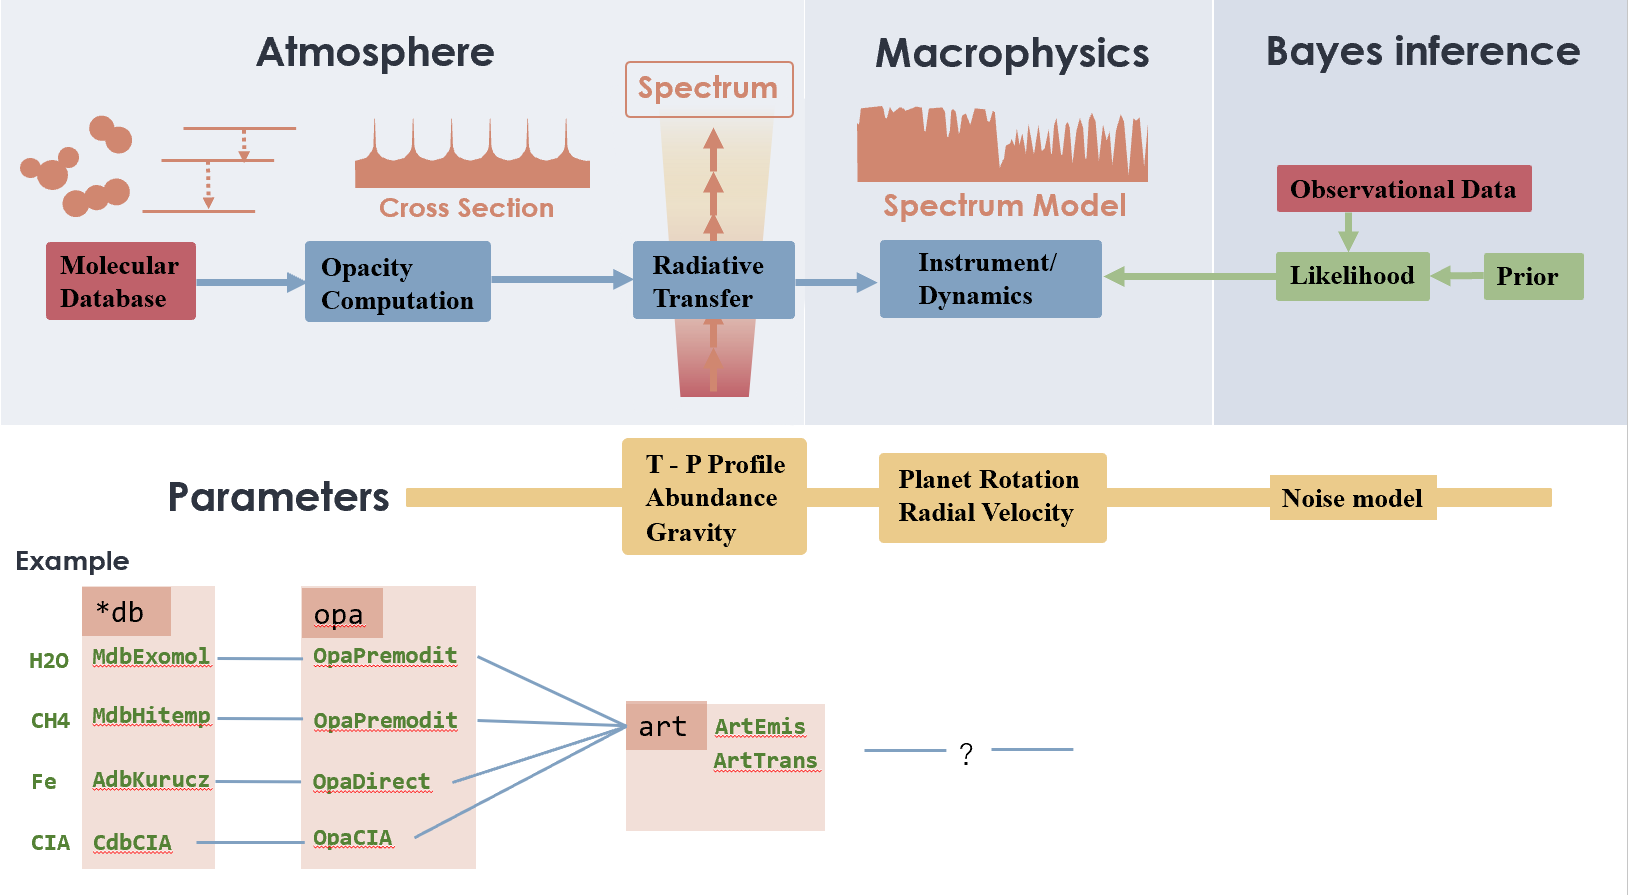

In [3]:
from IPython.display import Image
Image("../exojax.png")

## 1. Loading a molecular database using mdb.

ExoJAX has an API for molecular databases, called "mdb" (or "adb" for atomic datbases). Prior to loading the database, define the wavenumber range first.

In [4]:
from exojax.utils.grids import wavenumber_grid

nu_grid, wav, resolution = wavenumber_grid(1900.,
                                           2300.,
                                           100000,
                                           unit="cm-1",
                                           xsmode="premodit")


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit


/home/kawahara/exojax/src/exojax/utils/grids.py:126: UserWarning: Resolution may be too small. R=523403.606697253
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Then, let's load the molecular database. We here use Carbon monooxide in Exomol. CO/12C-16O/Li2015 means Carbon monooxide/ isotopes = 12C + 16O / database name. You can check the database name in the ExoMol website (https://www.exomol.com/).  

In [5]:
from exojax.spec.api import MdbExomol

mdb = MdbExomol(".database/CO/12C-16O/Li2015", nurange=nu_grid)


/home/kawahara/exojax/src/exojax/utils/molname.py:133: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


## 2. Computation of the Cross Section using opa

ExoJAX has various opacity calculator classes, so-called "opa". Here, we use a memory-saved opa, OpaPremodit. We assume the robust tempreature range we will use is 500-1500K.

In [6]:
from exojax.spec.opacalc import OpaPremodit

opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0])

OpaPremodit: params automatically set.
Robust range: 484.50562701065246 - 1804.6009417674848 K
Tref changed: 296.0K->521.067611616332K


uniqidx: 100%|██████████| 3/3 [00:00<00:00, 6675.28it/s]


Premodit: Twt= 1153.8856089961712 K Tref= 521.067611616332 K
Making LSD:|####################| 100%
Making LSD:|####################| 100%
Making LSD:|####################| 100%


Then let's compute cross section for two different temperature 500 and 1500 K for P=1.0 bar. opa.xsvector can do that!

In [7]:
P = 1.0 #bar
T_1 = 500.0 #K
xsv_1 = opa.xsvector(T_1, P) #cm2

T_2 = 1500.0 #K
xsv_2 = opa.xsvector(T_2, P) #cm2

Plot them. It can be seen that different lines are stronger at different temperatures.

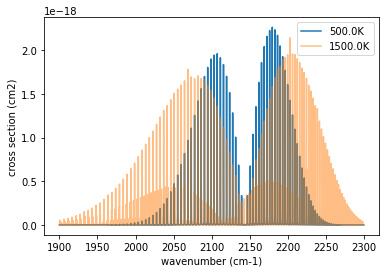

In [8]:
import matplotlib.pyplot as plt
plt.plot(nu_grid,xsv_1,label=str(T_1)+"K") #cm2
plt.plot(nu_grid,xsv_2,alpha=0.5,label=str(T_2)+"K") #cm2
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

You can also plot the line strengths at T=1500K. We can first change the mdb reference temperature and then plot the line intensity.

Tref changed: 521.067611616332K->1500.0K


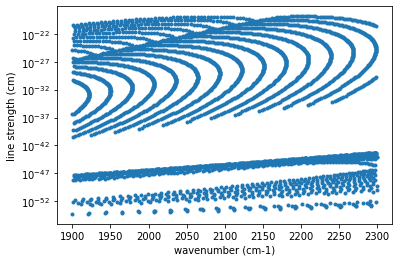

In [9]:
mdb.change_reference_temperature(T_2)
plt.plot(mdb.nu_lines,mdb.line_strength_ref,".")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("line strength (cm)")
plt.yscale("log")
plt.show()

ExoJAX can solve the radiative transfer and derive the emission spectrum. To do so, ExoJAX has "art" class. ArtEmisPure means Atomospheric Radiative Transfer for Emission with Pure absorption. So, ArtEmisPure does not include scattering.
We set the number of the atmospheric layer to 100 (nlayer) and the pressure at bottom and top atmosphere to 100 and 1.e-8 bar.

In [10]:
from exojax.spec.atmrt import ArtEmisPure
art = ArtEmisPure(nu_grid=nu_grid, pressure_btm=1.e2, pressure_top=1.e-8, nlayer=100)


Let's assume the power law temperature model, within 500 - 1500 K.

$T = T_0 P^\alpha$

where $T_0=1200$ K and $\alpha=0.1$.

In [11]:
art.change_temperature_range(500.0, 1500.0)
Tarr = art.powerlaw_temperature(1200.0,0.1)

Also, the mass mixing ratio of CO (MMR) should be defined.

In [12]:
mmr_profile = art.constant_mmr_profile(0.01)

Surface gravity is also important quantity of the atmospheric model, which is a function of planetary radius and mass. Here we assume 1 RJ and 10 MJ.

In [13]:
from exojax.utils.astrofunc import gravity_jupiter
gravity = gravity_jupiter(1.0,10.0)

In addition to the CO cross section, we would consider [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity. "cdb" class can be used.

In [14]:
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA

cdb = CdbCIA(".database/H2-H2_2011.cia",nurange=nu_grid)
opacia = OpaCIA(cdb, nu_grid=nu_grid)

H2-H2


Before running the radiative transfer, we need cross sections for layers, called xsmatrix for CO and logacia_matrix for CIA (strictly speaking, the latter is not cross section but coefficient because CIA intensity is proportional density square). 

In [15]:
xsmatrix = opa.xsmatrix(Tarr, art.pressure)
logacia_matrix = opacia.logacia_matrix(Tarr)

Convert them to opacity

In [16]:
dtau_CO = art.opacity_profile_lines(xsmatrix, mmr_profile, mdb.molmass, gravity)
vmrH2 = 0.855 #VMR of H2
mmw = 2.33 # mean molecular weight of the atmosphere
dtaucia = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2, mmw, gravity)

Add two opacities.

In [17]:
dtau = dtau_CO + dtaucia

Then, run the radiative transfer

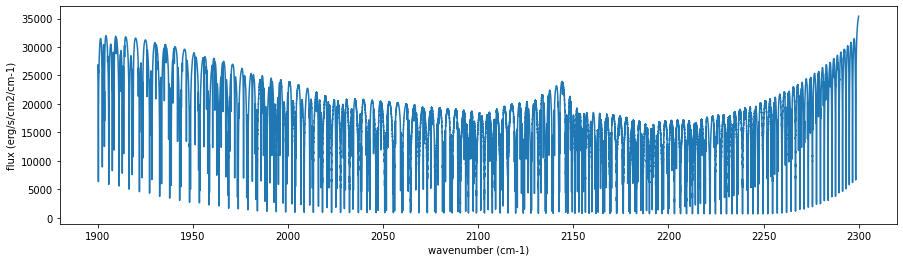

In [18]:
F = art.run(dtau, Tarr)

fig=plt.figure(figsize=(15,4))
plt.plot(nu_grid,F)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

You can check the contribution function too!

In [19]:
from exojax.plot.atmplot import plotcf

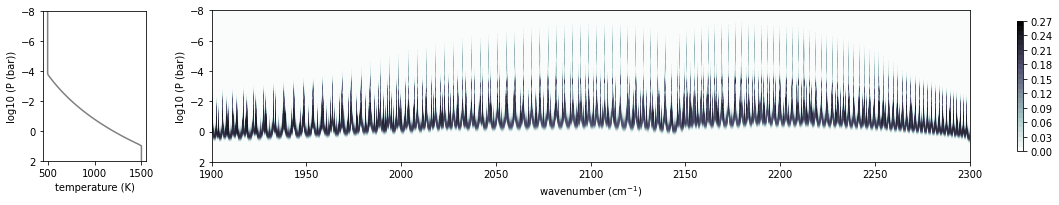

In [20]:
cf=plotcf(nu_grid, dtau, Tarr,art.pressure, art.dParr)

That's it. 